# ssGSEA

Single sample GSEA (ssGSEA) is a non-parametric method that calculates a gene set enrichment score per sample as the normalized difference in empirical cumulative distribution functions (CDFs) of gene expression ranks inside and outside the gene set.

+ Author: Margaret Paiva  

In [1]:
suppressWarnings(require('pkgmaker',quietly = T))
require('plyr',quietly = T)
l_ply(c('dplyr',
        'data.table',
        'tidyr',  
        'tibble',
        'jsonlite', 
        'rjson',
        'httr',
        'GSVA', 
        'limma', 
        'gridExtra'), function(pkg) {
          invisible(capture.output(irequire(pkg, quiet = T, autoinstall = T)))
        })

## Expression data

Uncomment the following code to download a set of data.

In [2]:
# # In "gene_list.csv", define a list of genes of interest
# gene_list  <- as.list(read.csv("gene_list.csv")$x)

In [6]:
# Enter the file name of the .json file in your root directory below
lt  <-  fromJSON(file = "./data/requested_data---19-10-2021---20_44_20.json")

In [ ]:
# Create a dataframe from the data
df  <- do.call(rbind, lapply(lt, rbind))
df  <- as.data.frame(df)
df$gene  <- as.character(df$gene)  # each column is a list - specify data type
df$model_name  <- as.character(df$model_name)
df$tumor_type  <- as.character(df$tumor_type)
df$z  <- as.numeric(df$z)
head(df, 2)
print(dim(df))

In [ ]:
# Pivot the data to have 'gene' as rows, 'model' as colomns, and 'log.tpm' as values
# pdx_mat <- df %>% 
#     select(c('gene', 'model', 'log.tpm'))  %>% 
#     pivot_wider(names_from = model, values_from = log.tpm)  %>% 
#     column_to_rownames('gene')
# pdx_mat  <- pdx_mat[complete.cases(pdx_mat),]  # remove rows with missing values

pdx_dat <- df %>% 
    select(c('gene', 'model_name', 'tumor_type', 'z'))
pdx_dat$z <- as.numeric(pdx_dat$z)
pdx_dat <- aggregate(pdx_dat['z'], by=pdx_dat[c('gene', 'model_name')], FUN=mean)
pdx_mat <- tidyr::pivot_wider(pdx_dat[c('z', 'gene', 'model_name')], 
                              names_from='model_name', values_from='z')
pdx_mat <- as.data.frame(pdx_mat)
rownames(pdx_mat) <- pdx_mat$gene
pdx_mat <- as.matrix(pdx_mat[-1])
pdx_mat[1:2, 1:10]
print(dim(pdx_mat))

## Gene sets from pathways

In [9]:
# This loads the variable `get_sets`
load("./requests/kegg_gene_sets.RData")

In [10]:
# get gene set for pathways
genesetfile <- tempfile()
geneset <- list()

for(set in get_sets) {
    x <- httr::GET('http://www.gsea-msigdb.org/gsea/msigdb/download_geneset.jsp',
        query=list(
            geneSetName = set,
            fileType = 'txt'
        ),
        httr::write_disk(genesetfile, overwrite = TRUE)
    )
    suppressMessages(geneset1 <- readr::read_tsv(genesetfile))
    geneset[set] <- as.list(geneset1)
#     Sys.sleep(0.5) # give the website a break
}
# first element in each geneset is a descriptor
geneset <- lapply(geneset, function(x) x[-1])

## ssGSEA scores

In [ ]:
pdx_gsva <- GSVA::gsva(as.matrix(pdx_mat), geneset, 
                       min.sz=10, max.sz=500, method='ssgsea')
pdx_gsva
print(dim(pdx_gsva))

## Plotting

In [12]:
pdx_dat <- df %>% 
    select(c('gene', 'model_name', 'tumor_type', 'z'))
cancertype <- unique(pdx_dat[c('model_name', 'tumor_type')])
cancertype <- cancertype[order(cancertype[,'tumor_type']),]
cancertype <- cancertype[cancertype[,'model_name'] %in% colnames(pdx_gsva),]
cancertype[,'tumor_type'] <- as.factor(cancertype[,'tumor_type'])
pdx_gsva <- pdx_gsva[, cancertype$model_name] # sort pdx_gsva to have the same order as cancertype for models
pdx_cl <- copy(pdx_gsva)

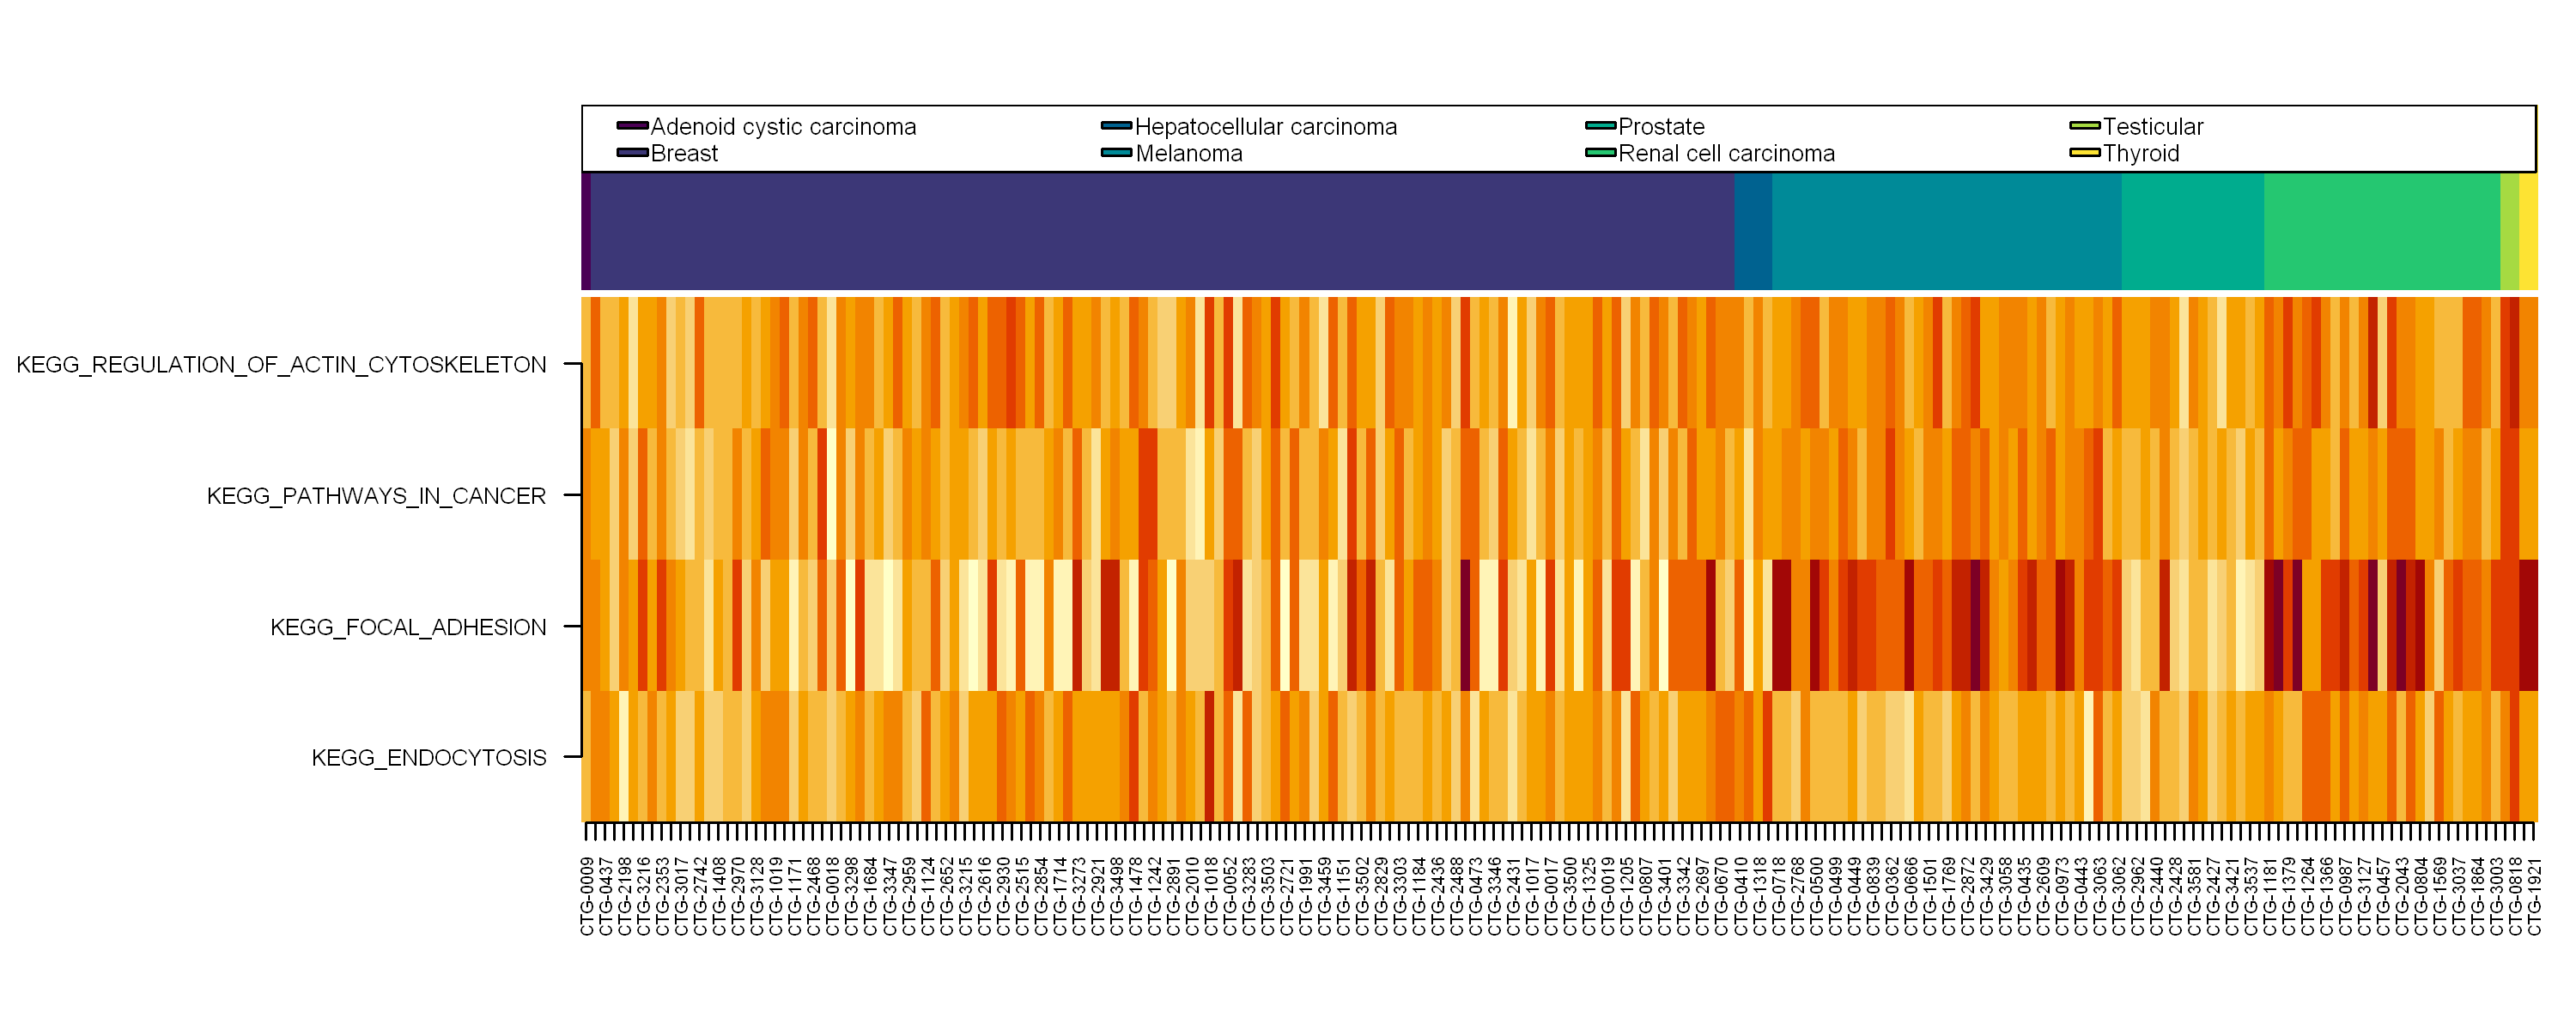

In [35]:
# Change plot size
options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=300)
# Layout 
graphics::layout(
    matrix(c(1, 1, 2, 2, 2, 2, 2), nrow = 7))

colorLegend <- hcl.colors(length(unique(cancertype$tumor_type)), "viridis")
par(mar=c(0,17,3,1)+0.1)
p1 <- image(
    matrix(as.numeric(cancertype[,'tumor_type'])), 
    axes=FALSE, 
    ann=FALSE, 
    main=NA, 
    col=colorLegend
)
names(colorLegend) <- unique(cancertype$tumor_type)
legend("topleft", legend=names(colorLegend), fill=colorLegend, 
       ncol=ceiling(length(unique(cancertype$tumor_type))/2), cex=0.808, 
       y.intersp=2, x.intersp=0.1)

par(mar=c(6,17,0,1)+0.1)
p2 <- image(x=0:ncol(pdx_cl), y=0:nrow(pdx_cl), z=t(pdx_cl), axes=FALSE, xlab=NA, ylab=NA)
axis(2, at=1:nrow(pdx_cl)-0.5, labels=rownames(pdx_cl), las=2, cex.axis=0.8)
axis(1, at=1:ncol(pdx_cl)-0.5, labels=colnames(pdx_cl), las=3, cex.axis=0.6)